This application fetches weather radar GIF images and constructs an animation.
NOAA generates images from all US radar stations every few minutes; delta is between 3 to 6 minutes.
The images are only guaranteed to be saved for one hour.
Documentation of this NOAA service: https://www.weather.gov/jetstream/ridge_download
Index of the recent files from station MUX (Mt. Umunhum, Silicon Valley radar): https://radar.weather.gov/ridge/RadarImg/N0R/MUX/
NOAA web page for current radar displayed with overlays: https://radar.weather.gov/ridge/radar.php?rid=mux&product=N0R&overlay=11101111&loop=no
You can also fetch NEXRAD raw data from AWS servers. This data goes back to 1992!
NEXRAD RAW needs to be processed to generate images. In Python I have found that it takes tens of seconds
to fetch the data and process it into images on my desktop system: this will never work on a Raspberry Pi.

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

In [2]:
# Fetch current GIF list from NOAA RIDGE system
rad_station = 'mux'
img_root_url = 'https://radar.weather.gov/ridge/RadarImg/N0R/'
img_dir_url = img_root_url + rad_station.upper()

import requests
#from BeautifulSoup import BeautifulSoup as bs
from HTMLParser import HTMLParser
r = requests.get(img_dir_url)
r.text


u'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<html>\n <head>\n  <title>Index of /ridge/RadarImg/N0R/MUX</title>\n </head>\n <body>\n<h1>Index of /ridge/RadarImg/N0R/MUX</h1>\n<table><tr><th><img src="/icons/blank.gif" alt="[ICO]"></th><th><a href="?C=N;O=D">Name</a></th><th><a href="?C=M;O=A">Last modified</a></th><th><a href="?C=S;O=A">Size</a></th><th><a href="?C=D;O=A">Description</a></th></tr><tr><th colspan="5"><hr></th></tr>\n<tr><td valign="top"><img src="/icons/back.gif" alt="[DIR]"></td><td><a href="/ridge/RadarImg/N0R/">Parent Directory</a></td><td>&nbsp;</td><td align="right">  - </td><td>&nbsp;</td></tr>\n<tr><td valign="top"><img src="/icons/image2.gif" alt="[IMG]"></td><td><a href="MUX_20190707_1818_N0R.gif">MUX_20190707_1818_N0R.gif</a></td><td align="right">07-Jul-2019 18:21  </td><td align="right"> 12K</td><td>&nbsp;</td></tr>\n<tr><td valign="top"><img src="/icons/image2.gif" alt="[IMG]"></td><td><a href="MUX_20190707_1826_N0R.gif">MUX_20190707_1826_N0R.

In [3]:
# to use HTMLParser I need to implement my own class?
class MyHTMLParser(HTMLParser):
    def __init__(self,station):
        #super(MyHTMLParser,self).__init__()   # new style super
        HTMLParser.__init__(self)    # old style super does not inherit from object
        self.images = []
        self.station = station
        
    def handle_starttag(self, tag, attrs):
        '''
        print "Start tag:", tag
        for attr in attrs:
            print "     attr:", attr
        '''
        if tag == 'a':
            for attr in attrs:
                if attr[0] == 'href':
                    if attr[1].startswith(self.station):
                        self.images.append(attr[1])

    def handle_endtag(self, tag):
        #rint "End tag  :", tag
        pass

    def handle_data(self, data):
        #rint "Data     :", data
        pass

hparse = MyHTMLParser('MUX')
hparse.feed(r.text)

In [4]:
# List of images is sorted with most recent at end
print 'Found images: %d' %(len(hparse.images))
print str(hparse.images)

Found images: 30
[u'MUX_20190707_1818_N0R.gif', u'MUX_20190707_1826_N0R.gif', u'MUX_20190707_1835_N0R.gif', u'MUX_20190707_1843_N0R.gif', u'MUX_20190707_1851_N0R.gif', u'MUX_20190707_1900_N0R.gif', u'MUX_20190707_1908_N0R.gif', u'MUX_20190707_1917_N0R.gif', u'MUX_20190707_1925_N0R.gif', u'MUX_20190707_1933_N0R.gif', u'MUX_20190707_1942_N0R.gif', u'MUX_20190707_1950_N0R.gif', u'MUX_20190707_1958_N0R.gif', u'MUX_20190707_2007_N0R.gif', u'MUX_20190707_2015_N0R.gif', u'MUX_20190707_2024_N0R.gif', u'MUX_20190707_2032_N0R.gif', u'MUX_20190707_2040_N0R.gif', u'MUX_20190707_2049_N0R.gif', u'MUX_20190707_2057_N0R.gif', u'MUX_20190707_2106_N0R.gif', u'MUX_20190707_2114_N0R.gif', u'MUX_20190707_2123_N0R.gif', u'MUX_20190707_2131_N0R.gif', u'MUX_20190707_2141_N0R.gif', u'MUX_20190707_2150_N0R.gif', u'MUX_20190707_2158_N0R.gif', u'MUX_20190707_2206_N0R.gif', u'MUX_20190707_2215_N0R.gif', u'MUX_20190707_2223_N0R.gif']


In [5]:
# Use only last hour of images
# Convert entire list to tuples with (datetime,str(datetime),image_name)
import datetime as dt

def img_name_tuple(imgfile):
    img_parse = imgfile.split('_')
    station = img_parse[0]
    img_date = img_parse[1]
    img_time = img_parse[2]
    #print img_date,img_time
    year = int(img_date[0:4])
    month = int(img_date[4:6])
    day = int(img_date[6:8])
    hour = int(img_time[0:2])
    minute = int(img_time[2:4])
    # TODO: what about timezone?
    dtobj = dt.datetime(year,month,day,hour,minute)
    dtstr = dtobj.strftime('%Y-%m-%d %H:%M')
    return (dtobj,dtstr,imgfile)

twindow = 70   # minutes of history
tdelta = dt.timedelta(minutes=twindow)
imgs = []
for img in hparse.images:
    img_tup = img_name_tuple(img)
    #print img_tup[1]
    imgs.append(img_tup)
end_time = imgs[-1][0]
start_time = end_time - tdelta
print 'end_time = %s, start = %s' %(end_time.strftime('%Y-%m-%d %H:%M'),start_time.strftime('%Y-%m-%d %H:%M'))

end_time = 2019-07-07 22:23, start = 2019-07-07 21:13


<IPython.core.display.Javascript object>


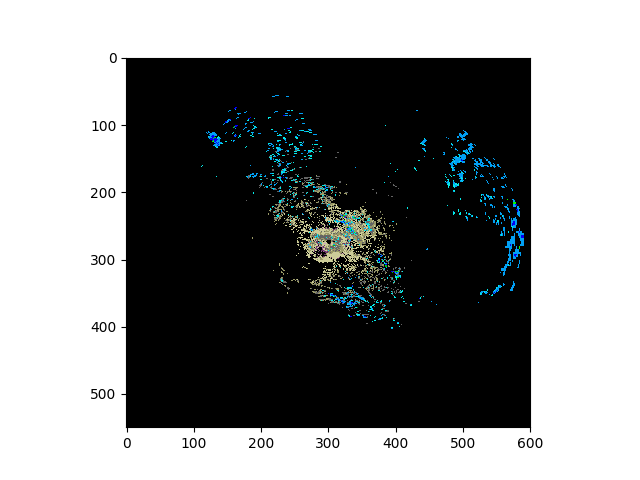

https://radar.weather.gov/ridge/RadarImg/N0R/MUX/MUX_20190707_2114_N0R.gif
https://radar.weather.gov/ridge/RadarImg/N0R/MUX/MUX_20190707_2123_N0R.gif
https://radar.weather.gov/ridge/RadarImg/N0R/MUX/MUX_20190707_2131_N0R.gif
https://radar.weather.gov/ridge/RadarImg/N0R/MUX/MUX_20190707_2141_N0R.gif
https://radar.weather.gov/ridge/RadarImg/N0R/MUX/MUX_20190707_2150_N0R.gif
https://radar.weather.gov/ridge/RadarImg/N0R/MUX/MUX_20190707_2158_N0R.gif
https://radar.weather.gov/ridge/RadarImg/N0R/MUX/MUX_20190707_2206_N0R.gif
https://radar.weather.gov/ridge/RadarImg/N0R/MUX/MUX_20190707_2215_N0R.gif
https://radar.weather.gov/ridge/RadarImg/N0R/MUX/MUX_20190707_2223_N0R.gif


In [6]:
imgs1 = [a for a in imgs if a[0] >= start_time and a[0] <= end_time]
fig,ax = plt.subplots()
ax.patch.set_facecolor('black')
from PIL import Image
import urllib2
ims = []
for f in imgs1:
    url = img_dir_url + '/' + f[2]
    print url
    request = urllib2.Request(url)
    pic = urllib2.urlopen(request)
    pil_im = Image.open(pic)
    new_im = Image.new("RGBA", pil_im.size)
    new_im.paste(pil_im)
    im = ax.imshow(new_im)
    ims.append([im])

In [7]:
ani = animation.ArtistAnimation(fig, ims, interval=250, blit=True,
                                repeat_delay=1000)

#ani.save('dynamic_images.mp4')

plt.show()